# Stacked regression

Here is my first attempt to solve [Kaggle's House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) challenge.

My objectives were:
1. Practice advanced nonlinear regression techniques
2. Practice on Hyper-parameters tuning with GridSearch
3. Practice with stacking of Regression models


# 1. First thing first

Imported everything I will need during this challenge. First look at the data, first assumptions.

In [121]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import cross_validation, grid_search, linear_model, metrics, preprocessing
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from mlxtend.regressor import StackingRegressor



df = pd.read_csv('train.csv')

Populating the interactive namespace from numpy and matplotlib


In [122]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [124]:
missing_data = df.isnull().sum().sort_values(ascending = False)
missing_data = missing_data[missing_data>0]
print(missing_data)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


# 2. Data processing
Handle missing data and multicollinearity

In [125]:
#For the sake of first attempt I deleted all missing values
df.drop(missing_data.index, axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 62 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotArea          1460 non-null int64
Street           1460 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-null object
ExterQual        1460 non-

In [126]:
# I've be using only numerical values, some of the features I excluded from the list after looking on a heatmap
list_of_numeric = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2',
                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'BsmtFullBath', 'BsmtHalfBath','FullBath',
                  'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
                  'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                  '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

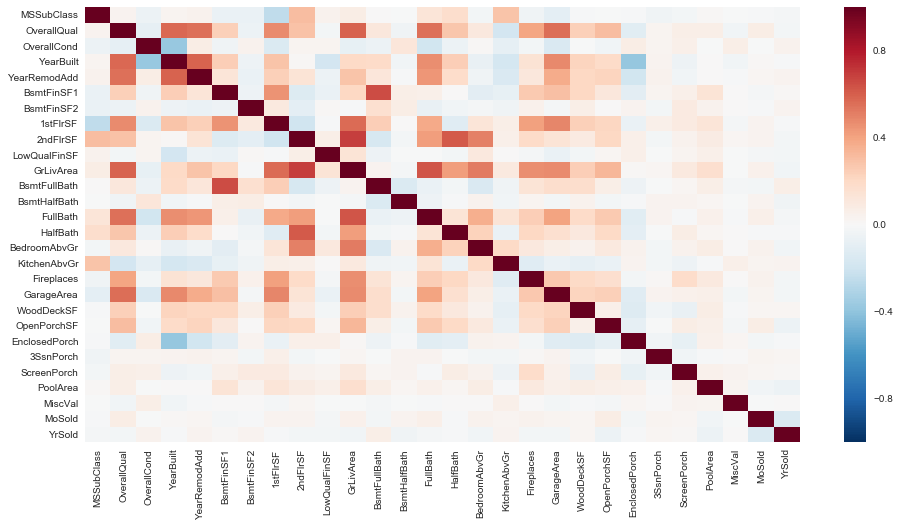

In [127]:
#Visualize to check correlation between featutres
pylab.figure(figsize=(16, 8))
sns.heatmap(df[list_of_numeric].corr())

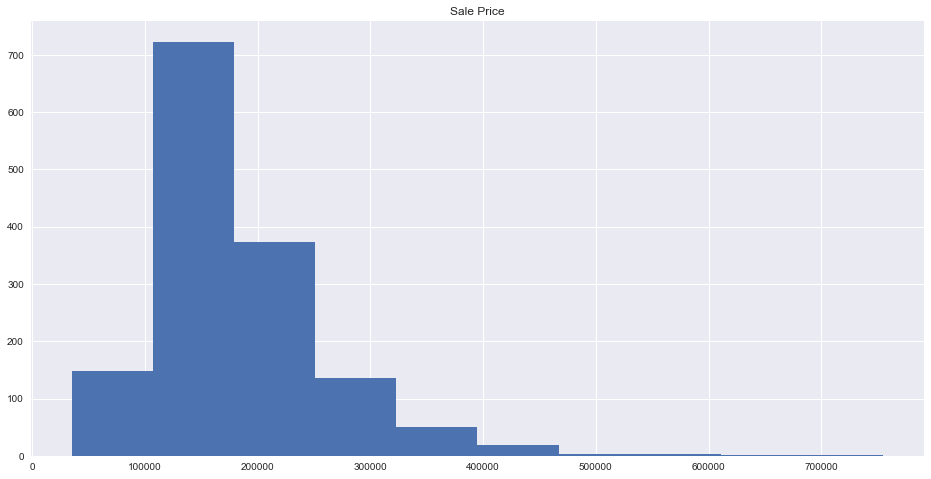

In [129]:
#Check the distridution of target value salePrice
pylab.figure(figsize=(16, 8))
pylab.hist(df.SalePrice)
pylab.title('Sale Price')

Because distribuition is skewed it will affect the linear regression model performanse. In order to overcome that I used Log-transformation

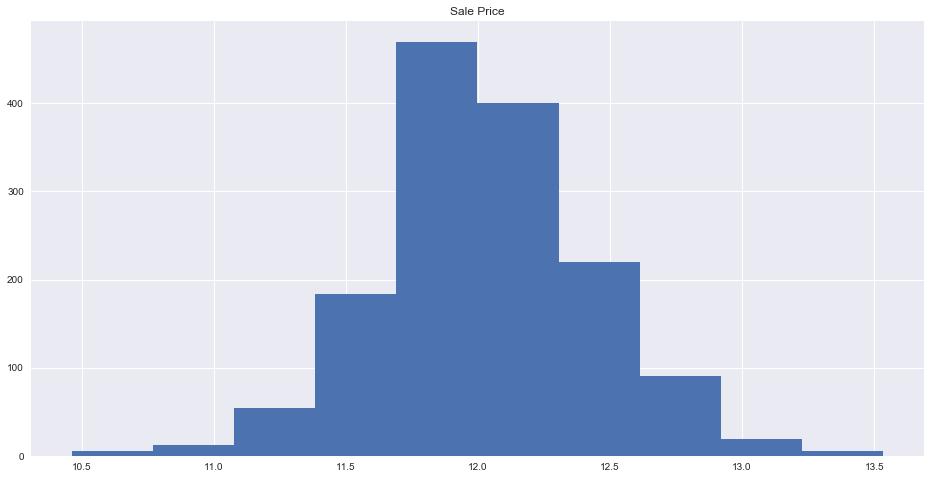

In [130]:
df["SalePrice"] = np.log1p(df["SalePrice"])
pylab.figure(figsize=(16, 8))
pylab.hist(df.SalePrice)
pylab.title('Sale Price')

Looking closily of available features, I desided, that GrLivArea - Gross Living Area is probably feature that will affect target value the most

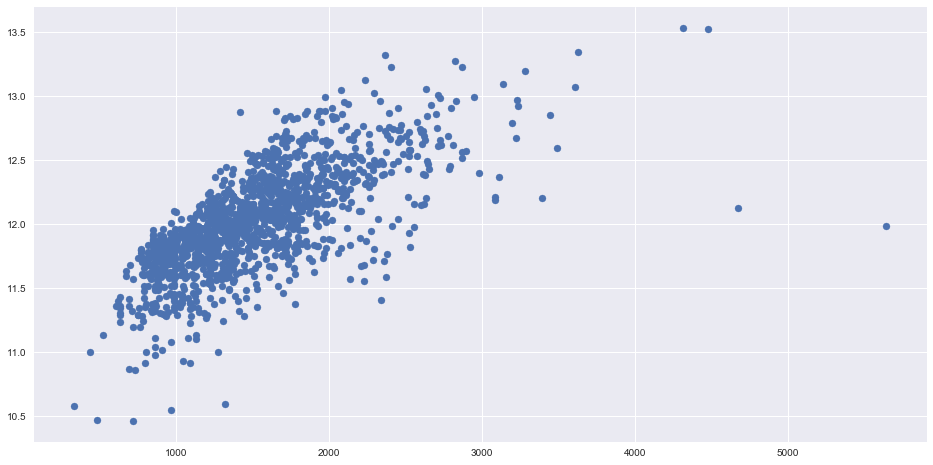

In [131]:
#Let's visualize this
pylab.figure(figsize=(16, 8))
pylab.scatter(df.GrLivArea, df.SalePrice)

Two outliers looks suspicious - Houses with big area for a very low price. From experimenting I concluded that this outliers affect result of prediction a lot.After reading comments on Kaggle, I cutted this points from dataset

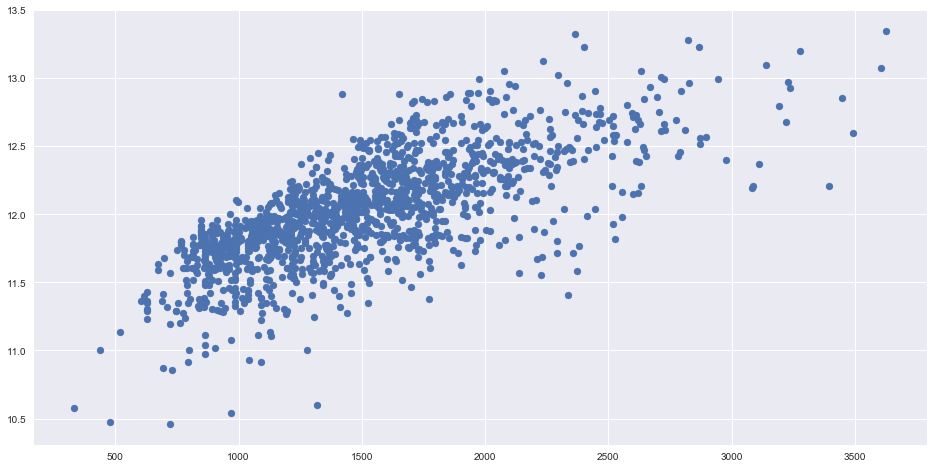

In [132]:
df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<200000)].index)
pylab.figure(figsize=(16, 8))
pylab.scatter(df.GrLivArea, df.SalePrice)

## Looking on the plot, heteroscedasticity of the target value can be clearly seen

In [133]:
#Split the data for training and testing data sets
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(df[list_of_numeric], 
                                                                                     df.SalePrice.values, 
                                                                                     test_size = 0.3,random_state = 0)


# 3. Create Basic models with default parameters

In [151]:
lasso = make_pipeline(RobustScaler(), Lasso())
GBoost = GradientBoostingRegressor()
ENet = make_pipeline(RobustScaler(), ElasticNet())
Rforest = RandomForestRegressor()

# 3.1 Evaluate

In [135]:
print('Model evaluation with default parameters')
print('Scoring - Mean Squared Log Error\n')
lasso.fit(train_data, train_labels)
print('Lasso {}'.format(metrics.mean_squared_log_error(test_labels, lasso.predict(test_data))))
GBoost.fit(train_data, train_labels)
print('GBoost {}'.format(metrics.mean_squared_log_error(test_labels, GBoost.predict(test_data))))
ENet.fit(train_data, train_labels)
print('ENet {}'.format(metrics.mean_squared_log_error(test_labels, ENet.predict(test_data))))
Rforest.fit(train_data, train_labels)
print('Rforest {}'.format(metrics.mean_squared_log_error(test_labels, Rforest.predict(test_data))))

Model evaluation with default parameters
Scoring - Mean Squared Log Error

Lasso 0.0009109704962351172
GBoost 9.696210718046636e-05
ENet 0.0009120460965020019
KRR 9.508082034261746e-05
Rforest 0.00011878561789228143


# 3.2 Visualize results

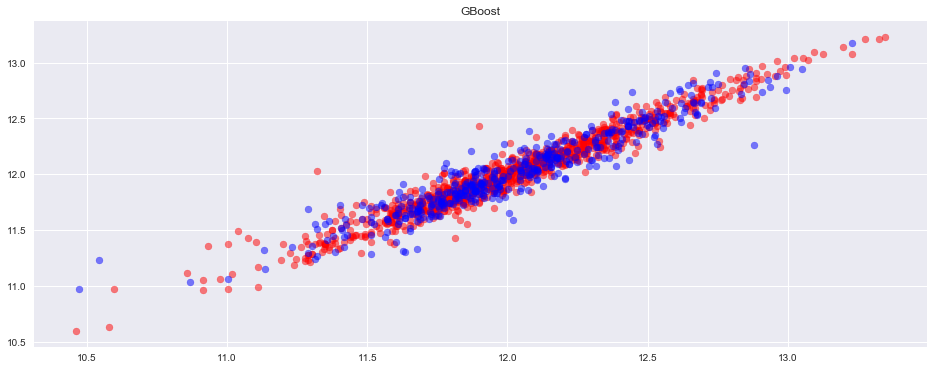

In [139]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.scatter(train_labels, GBoost.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, GBoost.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('GBoost')

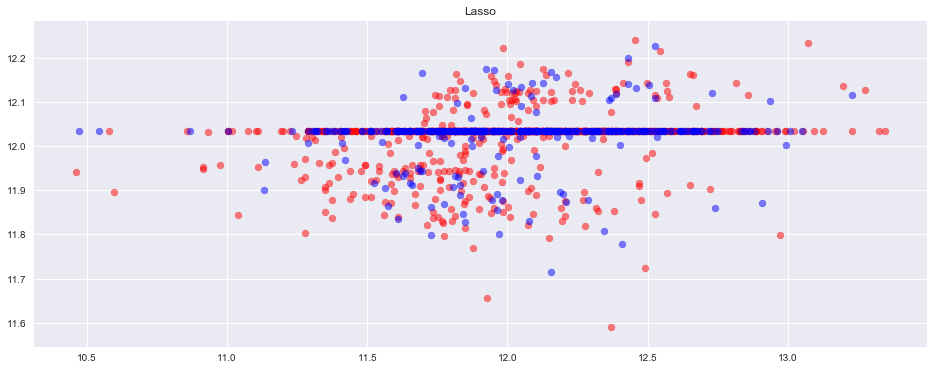

In [140]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.scatter(train_labels, lasso.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, lasso.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('Lasso')



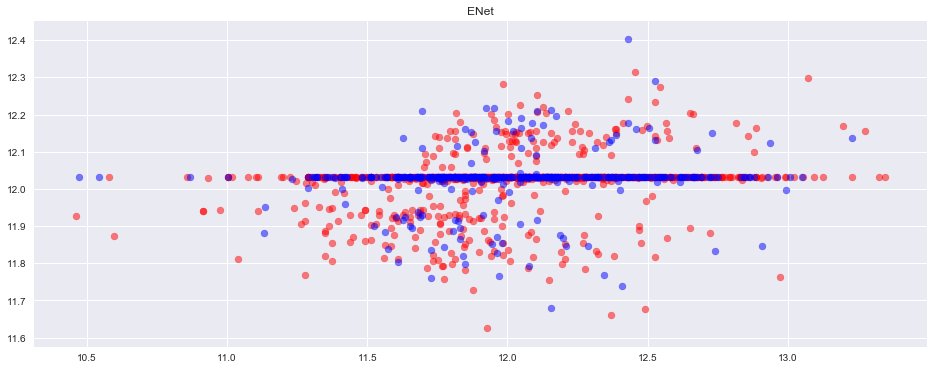

In [141]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.scatter(train_labels, ENet.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, ENet.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('ENet')

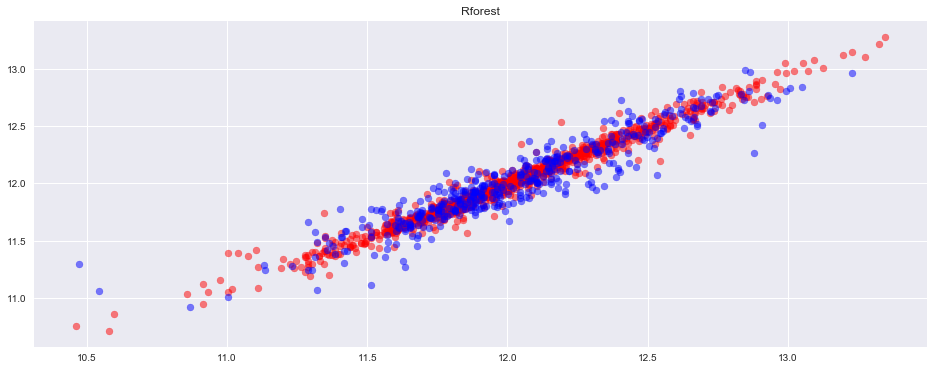

In [142]:
pylab.figure(figsize=(16, 6))

pylab.grid(True)
pylab.scatter(train_labels, Rforest.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, Rforest.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('Rforest')

# 3.3 Something not right with linear models
Lets use Grid Search to find better hyper-parameters

In [156]:
parameters_grid_lasso = {
                    'lasso__alpha': np.arange(0.0001,0.1, 0.01), 
                    'lasso__max_iter': [100, 500, 1000]}
grid_cv = grid_search.GridSearchCV(lasso, parameters_grid_lasso, scoring = 'neg_mean_squared_log_error', cv = 4)

#grid_cv.fit(train_data, train_labels)
#print (grid_cv.best_score_)
#print (grid_cv.best_params_)

#Results of the grid search
params_lasso = {'alpha': 0.0001, 'max_iter': 100}

In [155]:
parameters_grid_GBoost = {'n_estimators' : [1000, 1500, 3000], 
                          'learning_rate': [0.01, 0.05, 0.5 ], 
                          'max_depth'    : [2,4,10], 
                          'max_features' : ['sqrt', 'log2'], 
                          'min_samples_leaf' :[5,10,15,30], 
                          'min_samples_split':[5,10,15,30],
                          'loss': ['ls','lad','huber']}
grid_cv = grid_search.RandomizedSearchCV(GBoost, parameters_grid_GBoost, scoring = 'neg_mean_squared_log_error', 
                                         cv = 4,n_iter = 20, random_state = 0)

#grid_cv.fit(train_data, train_labels)
#print (grid_cv.best_score_)
#print (grid_cv.best_params_)

#Results of the grid search
params_GBoost = {'n_estimators' : 3000, 
                          'learning_rate': 0.01, 
                          'max_depth'    : 4, 
                          'max_features' : 'log2', 
                          'min_samples_leaf' :15, 
                          'min_samples_split':30,
                          'loss': 'huber'}


In [157]:
parameters_grid_ENet = {'elasticnet__alpha' : np.arange(0.0001,0.1, 0.01), 
                          'elasticnet__l1_ratio': np.arange(0.1,0.9, 0.1)}
grid_cv = grid_search.GridSearchCV(ENet, parameters_grid_ENet, scoring = 'neg_mean_squared_log_error', cv = 4)

#grid_cv.fit(train_data, train_labels)
#print (grid_cv.best_score_)
#print (grid_cv.best_params_)

params_ENet = {'alpha':0.0005, 'l1_ratio': 0.1}

In [161]:
%%time
parameters_grid_Rforest = {'n_estimators' : [10, 20, 50, 100, 1000],  
                          'max_depth'    : [2,4,10, 20], 
                          'max_features' : ['sqrt', 'log2'], 
                          'min_samples_leaf' :[5,10,15,30], 
                          'min_samples_split':[5,10,15,30]
                          }
grid_cv = grid_search.RandomizedSearchCV(Rforest, parameters_grid_Rforest, scoring = 'neg_mean_squared_log_error', 
                                         cv = 4,n_iter = 20, random_state = 0)

#grid_cv.fit(train_data, train_labels)
#print (grid_cv.best_score_)
#print (grid_cv.best_params_)

#Results of the grid search
params_Rforest = {'n_estimators' : 1000, 
                          'max_depth'    : 10, 
                          'max_features' : 'sqrt', 
                          'min_samples_leaf' :5, 
                          'min_samples_split':10
                 }

Wall time: 0 ns


# 3.4 Check the improvements

In [162]:
lasso = make_pipeline(RobustScaler(), Lasso(**params_lasso))
GBoost = GradientBoostingRegressor(**params_GBoost)
ENet = make_pipeline(RobustScaler(), ElasticNet(**params_ENet))
Rforest = RandomForestRegressor(**params_Rforest)

print('Model evaluation with tuned parameters')
print('Scoring - Mean Squared Log Error\n')
lasso.fit(train_data, train_labels)
print('Lasso {}'.format(metrics.mean_squared_log_error(test_labels, lasso.predict(test_data))))
GBoost.fit(train_data, train_labels)
print('GBoost {}'.format(metrics.mean_squared_log_error(test_labels, GBoost.predict(test_data))))
ENet.fit(train_data, train_labels)
print('ENet {}'.format(metrics.mean_squared_log_error(test_labels, ENet.predict(test_data))))
Rforest.fit(train_data, train_labels)
print('Rforest {}'.format(metrics.mean_squared_log_error(test_labels, Rforest.predict(test_data))))

Model evaluation with tuned parameters
Scoring - Mean Squared Log Error

Lasso 9.46842681599022e-05


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GBoost 8.705280776864951e-05
ENet 9.472379678984943e-05


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Rforest 0.00011083835615242759


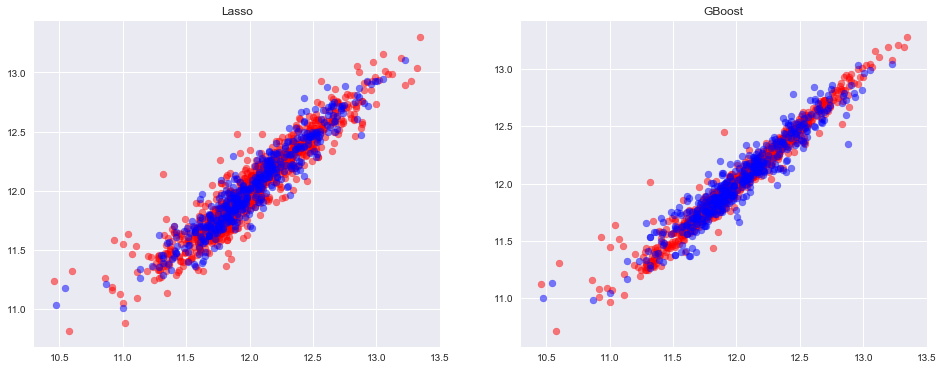

In [163]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, lasso.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, lasso.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('Lasso')


pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, GBoost.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, GBoost.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('GBoost')

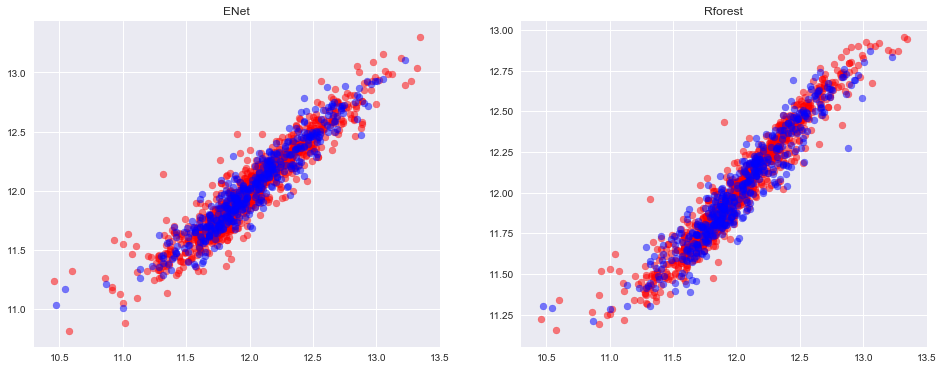

In [164]:
pylab.figure(figsize=(16, 6))

pylab.subplot(1,2,1)
pylab.grid(True)
pylab.scatter(train_labels, ENet.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, ENet.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('ENet')

pylab.subplot(1,2,2)
pylab.grid(True)
pylab.scatter(train_labels, Rforest.predict(train_data), alpha=0.5, color = 'red')
pylab.scatter(test_labels, Rforest.predict(test_data), alpha=0.5, color = 'blue')
pylab.title('Rforest')

## How linear models looks much better

# 4. It's stacking time!
Simplest way to create stucked regressor - with mlxtend.regressor

In [167]:
Stacked_regressor = StackingRegressor(regressors=[lasso, GBoost, ENet], 
                           meta_regressor=Rforest)
Stacked_regressor.fit(train_data, train_labels)
print('Stacked regressor error {}'.format(metrics.mean_squared_log_error(test_labels, Stacked_regressor.predict(test_data))))


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Stacked regressor error 8.292990556411731e-05


# 5. Make Kagge submission



In [169]:
test_data_submition = pd.read_csv('test.csv')
test_features = test_data_submition[list_of_numeric]

#Fill missing data with mean values
test_features.BsmtFinSF1=test_features.BsmtFinSF1.fillna(np.mean(test_features.BsmtFinSF1))
test_features.BsmtFinSF2=test_features.BsmtFinSF2.fillna(np.mean(test_features.BsmtFinSF2))
test_features.BsmtFullBath=test_features.BsmtFullBath.fillna(np.mean(test_features.BsmtFullBath))
test_features.BsmtHalfBath=test_features.BsmtHalfBath.fillna(np.mean(test_features.BsmtHalfBath))
test_features.GarageArea=test_features.GarageArea.fillna(np.mean(test_features.GarageArea))

prediction = np.expm1(Stacked_regressor.predict(test_features))
y_predict_test_data = pd.DataFrame({'Id': test_data_submition['Id'],
                                    'SalePrice':prediction})
y_predict_test_data.to_csv("Submition_Stack.csv")



C:\Anaconda3\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
